# This notebook explores the uncertainty from folding a known exponential spectra through the MagEIS geometric factors with uncertainty

In [44]:
import numpy as np
import pymc3 as pm
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.integrate
import scipy.interpolate
sns.set(font_scale=1.5)
%matplotlib inline
import sys

sys.path.append('../utils/')
import mageis_response

Create a true exponential spectra with E0t and J0t parameters. Then use that spectra and fold it through the MagEIS response functions to get the true counts.

In [45]:
# Spectra parameters
E0t = 100 # keV
J0t = 1E4 # 1/(cm^2 sr s keV)

# Initialize the response function
R = mageis_response.R_iso(101) # RBSP-A MagEIS LOW.
E = R.E*1000 # Energy array in keV.
FEDU_energy = [ 15.,  20.,  33.,  54.,  80., 108., 143., 184., 226.] # keV
n_ch = (1, 9) # Channels to use (1 through 9 are the main rate channels.)

# Interpolate the response functions so we can easily add uncertainty to them
# G is a function of energy that returns G(E) for all energy channels.
G = scipy.interpolate.interp1d(E, [R.response(i) for i in range(*n_ch)], axis=1)

# Define an exponential spectra.
def spectra(Earr, J0, E0):
    return(J0*np.exp(-Earr/E0))

# Now create the "true" counts drawn from the parent distribution. This assumes there
# is no uncertanity.
true_lambda = np.nan*np.zeros(n_ch[1]-n_ch[0])
for i in range(*n_ch):
    true_lambda[i-n_ch[0]] = scipy.integrate.trapz(spectra(E, J0t, E0t)*R.response(i), x=E)

Since pymc3 does not natively do integrationm, now we code in a trapezium integrator (validated). Also define a pumc3 exponential spectra.

In [46]:
def pymcTrapz(f, x):
    """
    This function is the pymc3 Trapz implementation for an uneven grid.
    It integrates a function f over an uneven grid x.
    """
    return 0.5*pm.math.dot((f[1:] + f[:-1]), (x[1:] - x[:-1]))

def pymcExpSpectra(E, E0, J0):
    return J0*pm.math.exp(-E/E0)

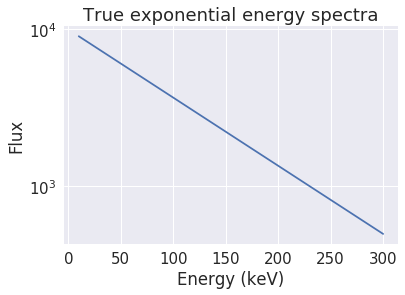

In [47]:
plt.plot(E, spectra(E, J0t, E0t)); plt.title('True exponential energy spectra')
plt.yscale('log'); plt.xlabel('Energy (keV)'); plt.ylabel('Flux');

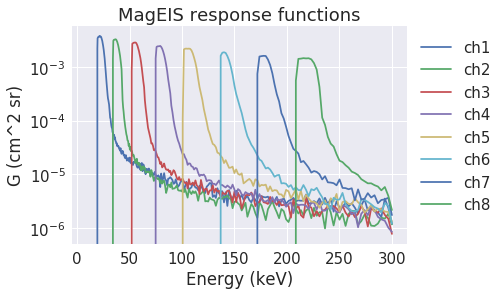

In [48]:
for i in range(*n_ch):
    plt.plot(E, R.response(i), label='ch{}'.format(i));
plt.xlabel('Energy (keV)'); plt.ylabel('G (cm^2 sr)'); 
plt.title('MagEIS response functions'); plt.yscale('log');
plt.legend(bbox_to_anchor=(1, 1)); #plt.savefig('response.png', dpi=300)

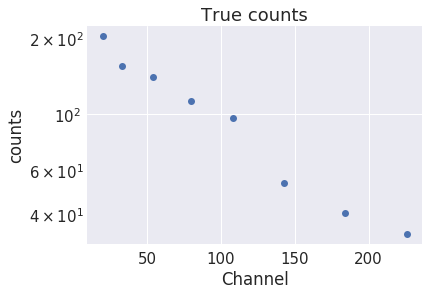

In [49]:
plt.semilogy(FEDU_energy[n_ch[0]:n_ch[1]], true_lambda, 'o'); 
plt.ylabel('counts'); plt.xlabel('Channel'); plt.title('True counts');

Now add realism by drawing observed counts from true_lambda assuming a Poisson process

In [50]:
np.random.seed(123)
c_obs = np.random.poisson(true_lambda)

Visualize the counts derived from the spectra without uncertainty, and the counts that could have been observed if we assume a poisson process

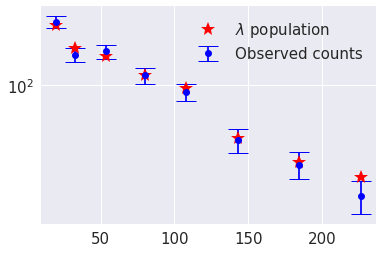

In [51]:
(_, caps, _) = plt.errorbar(FEDU_energy[n_ch[0]:n_ch[1]], c_obs, yerr=np.sqrt(c_obs), c='b', fmt='o', 
                            label='Observed counts', capsize=10)
for cap in caps:
    cap.set_markeredgewidth(1)
plt.plot(FEDU_energy[n_ch[0]:n_ch[1]], true_lambda, 'r*', ms=15, 
         label=r'$\lambda$ population')
plt.yscale('log'); plt.legend();

### Bayes model
Here we explore how to back out the exponential spectra from the observed counts. We work with informed and uninformed spectral parameter priors (switch below) and add uncertnaity to the response functions (scale up/down, move left/right).

In [52]:
informedPrior = True # use uniform or normal priors on J0 and E0.
# This sets the R(E) scale to unity or normally distributed.
# If False, will not modify the response functions.
Roffset = 0 # R(E) fwhm amplitude offset off if 0 (percent) 
Eoffset = 0 # R(E) fwhm energy offset off if 0 (percent)

def getPriors(informedSpecP, Roffset, Eoffset):
    """
    This function handles the exponential spectra priors, 
    and can add uncertnaity to the G(E) emplitude and
    energy offset.
    """
    if informedSpecP:
        BoundedNormal = pm.Bound(pm.Normal, lower=0.0)
        J0 = BoundedNormal('J0', mu=1E4, sd=1E5)
        E0 = BoundedNormal('E0', mu=100, sd=500)
    else:
        J0 = pm.Uniform('J0', lower=0, upper=1E7)
        E0 = pm.Uniform('E0', lower=0, upper=500)
    
    # G(E) modifications
    if Roffset:
        Roff = pm.Normal('Roff', mu=1, 
                         sd=Roffset/(100*2*np.sqrt(2*np.log(2))), 
                         shape=len(c_obs))
    else:
        Roff = np.ones_like(c_obs)
    if Eoffset:
        Eoff = pm.Normal('Eoff', mu=1, 
                         sd=Eoffset/(100*2*np.sqrt(2*np.log(2))), 
                         shape=len(c_obs))
    else:
        Eoff = np.ones_like(c_obs)
    return E0, J0, Roff, Eoff

def lam(E0, J0, Roffset, Eoffset):
    """
    This function appears to the only way to correctly work with pymc3 and 
    propagate the sampled spectra though the instrument response functions.
    My implementation of trapezium is not the fastest, but it will do.
    """
    lams = len(c_obs)*[None]
    
    for i in range(len(c_obs)):
        J = pymcExpSpectra(E*Eoffset[i], E0, J0)
        #f is chanel-dependent offset * flux arr * interpolated 
        # G(E * a random energy offset)
        f = Roffset[i]*J*G(E)[i]  #G(E*Eoffset[i])[i] 
        lams[i] = pm.Deterministic('lam{}'.format(i), pymcTrapz(f, E))
    return lams

m = pm.Model()
with m:
    # Prior stocastic variables
    prior = getPriors(informedPrior, Roffset, Eoffset)
    lams = lam(*prior) # Get prior determanistic variables
    
    c_m = pm.Poisson('c_m', mu=lams, observed=c_obs, shape=len(c_obs)) # Likelyhood
    trace = pm.sample(1E4, tuning=1000, cores=3) # MCMC

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [E0_lowerbound__, J0_lowerbound__]
100%|██████████| 10500/10500.0 [00:24<00:00, 428.11it/s]
The acceptance probability does not match the target. It is 0.8786371833285983, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8968069293301755, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8885057784431493, but should be close to 0.8. Try to increase the number of tuning steps.


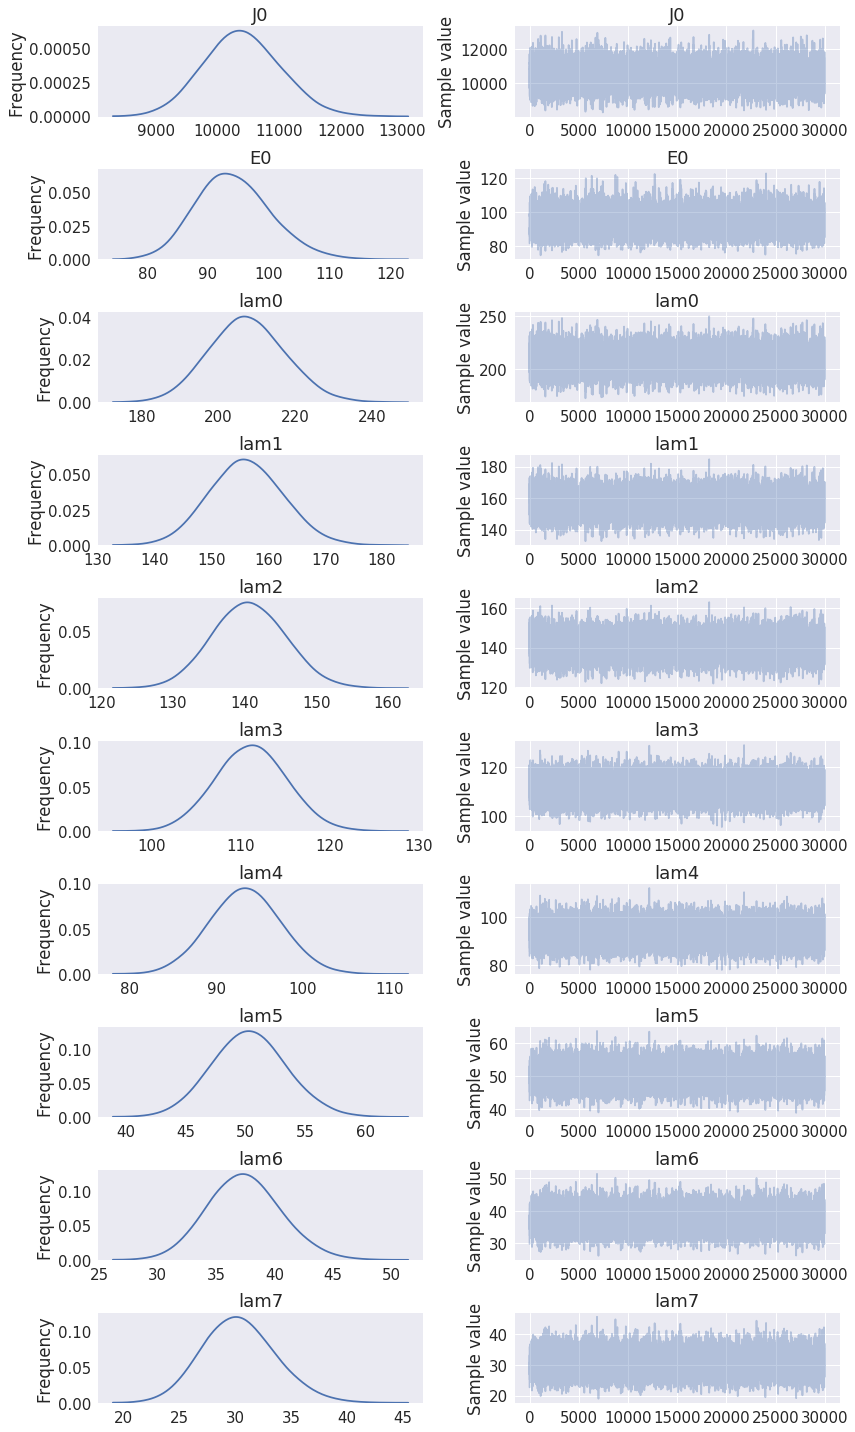

In [53]:
pm.traceplot(trace, combined=True);

In [54]:
pm.summary(trace)

mean          sd  mc_error      hpd_2.5      hpd_97.5  \
J0    10396.034595  625.949778  6.774677  9186.850026  11631.047514   
E0       94.145423    6.131517  0.068990    82.688220    106.611206   
lam0    207.407587    9.841707  0.098224   187.657597    225.996166   
lam1    156.004008    6.465660  0.058436   143.291244    168.491635   
lam2    140.546340    5.092301  0.036228   130.548466    150.338350   
lam3    111.134494    3.981736  0.020409   103.394687    118.941605   
lam4     93.310907    4.087159  0.026122    85.130419    101.125775   
lam5     50.283789    3.079740  0.025841    44.249589     56.316326   
lam6     37.377647    3.113667  0.029392    31.385015     43.564180   
lam7     30.297523    3.271304  0.032699    24.105911     36.850320   

             n_eff      Rhat  
J0     7611.477896  0.999983  
E0     7615.690506  1.000000  
lam0   8773.631349  0.999976  
lam1  10490.001915  0.999969  
lam2  16277.384182  0.999957  
lam3  31885.078613  0.999951  
lam4  24124.638022  0.999960  
lam5  14059.842519  0.999974  
lam6  11075.861234  0.999982  
lam7   9850.620422  0.999988

In [55]:
c_mean = [np.mean(trace['lam{}'.format(i)]) for i in range(len(c_obs))]
c_std = [np.std(trace['lam{}'.format(i)]) for i in range(len(c_obs))]
c_ci = np.asarray([np.percentile(trace['lam{}'.format(i)], (2.5, 97.5)) 
                    for i in range(len(c_obs))])

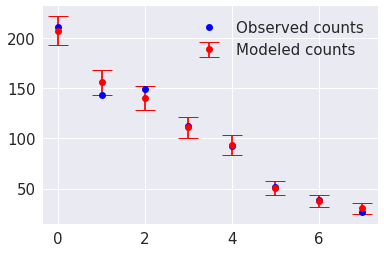

In [56]:
(_, caps, _) = plt.errorbar(range(len(c_obs)), c_mean, yerr=np.sqrt(c_mean), 
                            c='r', fmt='o', capsize=10, label='Modeled counts'); 
for cap in caps:
    cap.set_markeredgewidth(1)
plt.plot(range(len(c_obs)), c_obs, 'bo', label='Observed counts'); 
plt.legend();

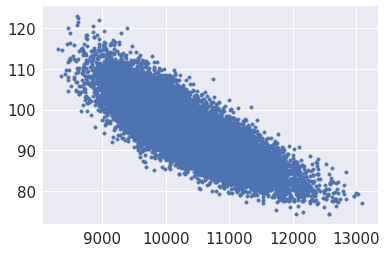

In [57]:
plt.scatter(trace['J0'], trace['E0'], marker='.');

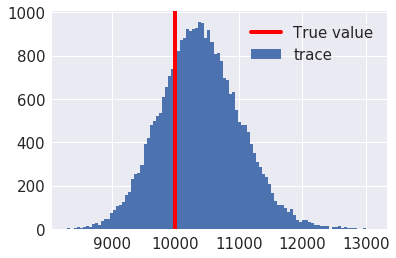

In [58]:
plt.hist(trace['J0'], bins=100, label='trace')
plt.axvline(J0t, c='r', lw=4, label='True value');
plt.legend();

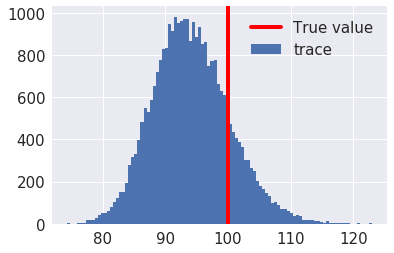

In [59]:
plt.hist(trace['E0'], bins=100, label='trace');
plt.axvline(E0t, c='r', lw=4, label='True value');
plt.legend();

## Posterior post predictive checks
Here we draw samples from the posterior distribution and check if the calculated counts from the picked E0 and J0 values are consistant with the data. Essentialy, we are looking to see if the observed counts are inside the drawn posterior distribution. 

In [60]:
ppc = pm.sample_ppc(trace, samples=2000, model=m)

100%|██████████| 2000/2000 [00:02<00:00, 981.73it/s]


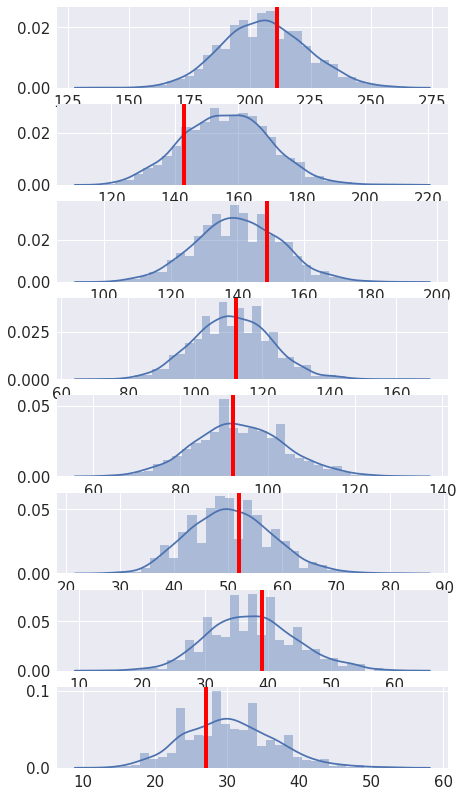

In [61]:
fig, ax = plt.subplots(len(c_obs),1, figsize=(7,14))
for i in range(len(c_obs)):
    sns.distplot(ppc['c_m'][:,i], ax=ax[i])
    ax[i].axvline(c_obs[i], c='r', lw=4)

## Statistics of the J0 and E0 distributions that are consistant with the observed counts 
Now we calculate the statistics of 100 spectra drawn from the trace (mean, median, 2.5%, and 95% credible interval) as a function of energy

Pick 100 random draws of E0 and J0 from the trace, and calculate the statistics on those draws as a function of energy.

In [62]:
nS = 100
random_samples = np.random.randint(0, len(trace), nS)
dist = np.zeros((len(E), nS), dtype=float)
for (i, s) in enumerate(random_samples):
    for e in range(len(E)):
        dist[e, i] = spectra(E, trace['J0'][s], trace['E0'][s])[e]

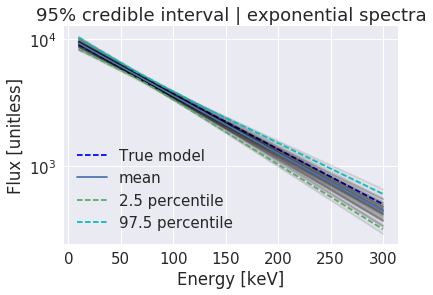

In [63]:
plt.plot(E, spectra(E, J0t, E0t), 'b--', label='True model')
for i in random_samples:
    plt.plot(E, spectra(E, trace['J0'][i], trace['E0'][i]), c='k', alpha=0.07)
plt.plot(E, np.mean(dist, axis=1), label='mean');
plt.plot(E, np.percentile(dist, 2.5, axis=1), '--', label='2.5 percentile')
plt.plot(E, np.percentile(dist, 97.5, axis=1), '--', label='97.5 percentile', c='c')
plt.legend(); plt.yscale('log'); plt.ylabel('Flux [unitless]');
plt.xlabel('Energy [keV]'); plt.title('95% credible interval | exponential spectra');

Calculate the credible intervals for E0 and J0

In [64]:
J0_ci = np.percentile(trace['J0'], (2.5, 97.5)); 
E0_ci = np.percentile(trace['E0'], (2.5, 97.5));

print('J0_ci = {}, E0_ci = {}'.format(J0_ci, E0_ci))

J0_ci = [ 9215.5613342  11673.51511238], E0_ci = [ 83.07216769 107.17490721]
